## [WORK IN PROGRESS] Exploring CUPED (aka Control Variates)

Imagine for a moment that you are a data scientist. A few engineers at your company have proposed a new feature, and you are tasked with running an experiment to assess the feature's potential impact on revenue. The experiment runs smoothly. However, when you reach the analysis stage, you get a p-value of 0.07, just above the typical p<0.05 threshold for significance. Hesitant to advocate for the feature without stronger evidence, you collect more data and obtain a p-value below 0.05. 

The scenario presented above is less than ideal. Each data point we collect costs time and money, so we would like to minimize the amount of data we need to make strong statistical claims. In general, we can only increase our statistical confidence in two ways: collect more data or decrease variance in our estimates. Since we want to minimize type spent in experimentation (and therefore provide better features faster), we need to think about decrease the variance in our estimates. There are *lots* of ways to do this, but here I'm going to focus on CUPED, also known as control variates. To keep this post brief, I'm going to assume some familiarity with causal inference and the potential outcomes framework. 

### Preliminaries

Let's start with some notation. Let $Y$ be our outcome of interest and $T$ be our treatment indicator such that $T=0$ is the control group and $T=1$ denotes the treatment group. Suppose we have $n$ units in our experiment. In a simple random experiment, we randomly assign $n_t$ units to treatment and assign the remainder, $n_c=n-n_t$, to control. 

In causal inference, the most common quantity of interest is the *average treatment effect*, that is the difference in the average outcome of treament and control. We use $\tau$ to denote the true average treatment effect (ATE).

### The Default: Difference-in-Means

A natural estimator of the ATE is
$$\hat{\tau}_{diff} = \frac{1}{n_t}\sum_{i=1}^nY_iT_i - \frac{1}{n_c}\sum_{i=1}^nY_i(1-T_i)$$
where we take the difference in the observed average outcome between treatment and control. Equivalently, we can use a linear regression of the form
$$Y = \hat{\alpha} + \hat{\tau}_{reg} T$$
to obtain $\hat{\tau}_{diff}=\hat{\tau}_{reg}$. This estimator, referred to as the difference-in-means (DiM) method, is compelling in its simplicity. However, DiM does not provide any mechanism for reducing variance, instead requiring more data to reduce uncertainty. In most experiments, we have some information that is related to the outcome. For example, in a clinical trial, a patient's age may be related to their risk of disease. If we don't use this information, we needlessly throw away potential efficiency gains (i.e. variance reduction).

### Simple Yet Powerful: CUPED
Here is where CUPED comes to the rescue. Suppose we have some variable $X$ that we've measured before the experiment begins. In the simplest terms, CUPED subtracts out the variance in $Y$ that is due to $X$, thereby reducing variance in our estimates. Specifically, we define $\tilde{Y} = Y - \theta(X-\mathbb{E}[X])$, where $\theta$ is any constant. We then apply DiM to $\tilde{Y}$, such that
$$\hat{\tau}_{cv} =  \frac{1}{n_t}\sum_{i=1}^n\tilde{Y}_iT_i - \frac{1}{n_c}\sum_{i=1}^n\tilde{Y}_i(1-T_i)$$
$\hat{\tau}_{cv}$ is an unbiased estimator with $var(\hat{\tau}_{cv}) \leq var(\hat{\tau}_{diff})$.

This feels a little too easy, right? That's part of the beauty of CUPED! The theory is simple to understand as well. Since we are using random assignment, and since $X$ is measured *before* the experiment, $\mathbb{E}[X|T=1] = \mathbb{E}[X|T=0]$. 

### What About Regression?: Regression Adjustment

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from cuped_utils import *

In [5]:
data = cuped_generator()
reg = smf.ols("Post_trigger ~ Treatment",data).fit()
reg.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Post_trigger   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
No. Observations:                 500   F-statistic:                     9.640
Covariance Type:                  HC2   Prob (F-statistic):            0.00201
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0120      0.132     60.518      0.000       7.752       8.272
Treatment      0.6232      0.201      3.105      0.002       0.229       1.018
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [5]:
cuped_lm = sm.OLS(data['Post_trigger'], data['Pre_trigger']).fit()
theta = cuped_lm.params[0]
data['Post_cuped'] = data['Post_trigger'] - theta*data['Pre_normalized']
cuped_reg = smf.ols("Post_cuped ~ Treatment", data).fit()
cuped_reg.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Post_cuped   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
No. Observations:                 500   F-statistic:                     11.98
Covariance Type:                  HC2   Prob (F-statistic):           0.000584
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0786      0.096     83.955      0.000       7.890       8.268
Treatment      0.4845      0.140      3.461      0.001       0.209       0.759
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [8]:
reg_adj = smf.ols(
    formula="Post_trigger ~ Treatment + Pre_trigger + Treatment:Pre_normalized",
    data=data).fit()
reg_adj.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Post_trigger   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
No. Observations:                 500   F-statistic:                     998.5
Covariance Type:                  HC2   Prob (F-statistic):          8.26e-175
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.1204      0.128     24.396      0.000       2.869       3.372
Treatment       0.5360      0.093      5.760      0.000       0.353       0.719
Pre_trigger     0.9726      0.022     43.843      0.000       0.929       1.016
===============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

<AxesSubplot:xlabel='estimate', ylabel='Density'>

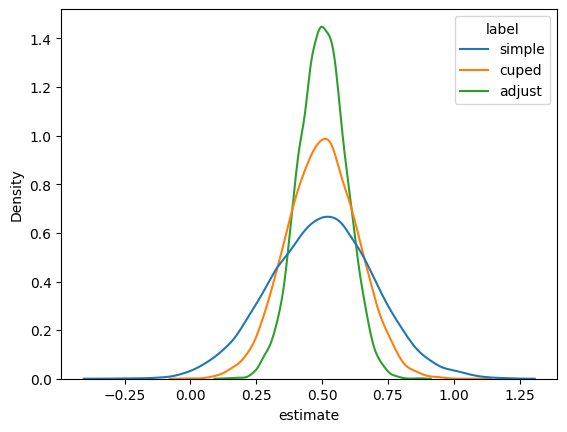

In [4]:
n = 10000
sample_size = 500
simple, cuped, adjust = many_cuped_sims(n_sims=n)
df = pd.DataFrame()
simple_df = pd.DataFrame({'label':['simple']*n, 'estimate':simple})
cuped_df = pd.DataFrame({'label':['cuped']*n, 'estimate':cuped})
adjust_df = pd.DataFrame({'label':['adjust']*n, 'estimate':adjust})

df = df.append([simple_df, cuped_df, adjust_df])
sns.kdeplot(x='estimate', hue = 'label', data=df)